In [118]:
import pandas
import matplotlib.pyplot as plt 
import os
import torch
import random
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from dataset_loaders import NYUV2DataSet

from transformers import AutoModelForDepthEstimation, AutoImageProcessor
from torchvision import transforms

In [119]:
depth_anything_small = pandas.read_csv("results/Depth-Anything-V2-Small-hf_results.csv")

In [ ]:
def plot_inference_time_and_model_size(model_name):
    depth_results_df = pandas.read_csv(os.path.join("results", model_name + "-hf_results.csv"))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    fig.suptitle("Inference Time and Model Size Results for " + model_name)

    depth_results_df.plot.bar(x="config_name",
                                y=["nyu2_time","da2k_time"], 
                                rot=0, 
                                ylabel="Average Inference Time (ms)",
                                xlabel="Quantization Setting",
                                title="Inference Time on NYU2K and DA2K Datasets", 
                                ax=axes[0])

    depth_results_df.plot.bar(x="config_name", 
                                y="model_size", 
                                ylabel="Model Size (Megabytes)", 
                                xlabel="Quantization Setting",
                                title="Model Size in Megabytes",
                                ax=axes[1],
                                rot=0)

    plt.show()

### Display Graphs for Quantization Results

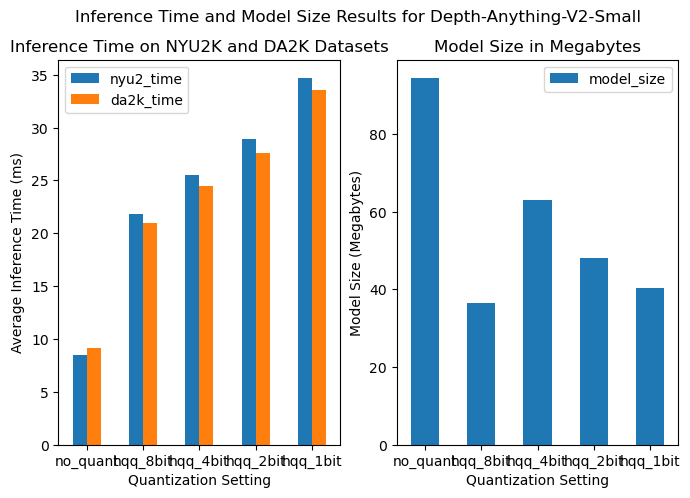

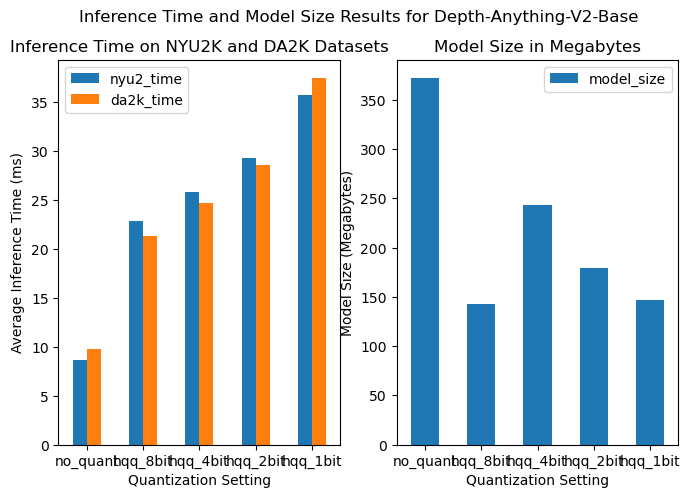

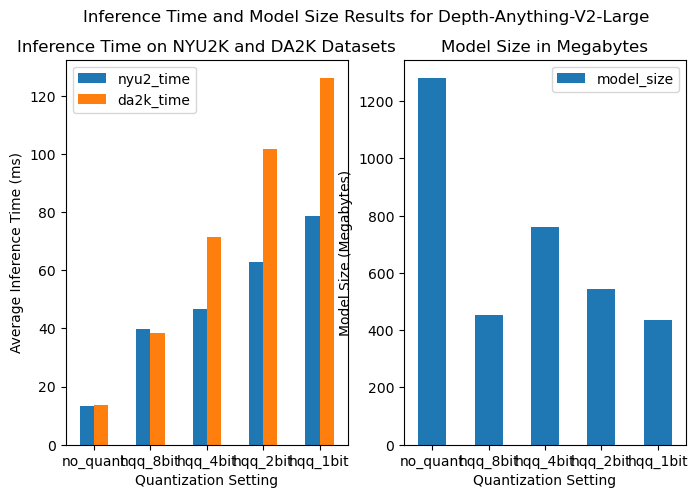

In [125]:
model_list = ["Depth-Anything-V2-Small","Depth-Anything-V2-Base","Depth-Anything-V2-Large"]
for model in model_list:
    plot_inference_time_and_model_size(model)

### Display Tables for Quantization Results

In [122]:
def print_table(model_name):
    depth_results_df = pandas.read_csv(os.path.join("results", model_name + "-hf_results.csv"))
    display(HTML("<h3> Quantization Results for " + model_name + "</h3>"))
    display(HTML(depth_results_df.to_html(header=True)))

In [123]:
for model in model_list:
    print_table(model)

,config_name,abs_rel,d1,accuracy,nyu2_time,da2k_time,model_size
0,no_quant,0.998693,0.0,0.498548,8.500000,9.148112,94.555176
1,hqq_8bit,0.998694,0.0,0.499516,21.795107,20.994192,36.572754
2,hqq_4bit,0.998729,0.0,0.505324,25.515291,24.482091,63.027344
3,hqq_2bit,0.997940,0.0,0.471442,28.967890,27.554695,48.159180
4,hqq_1bit,0.999128,0.0,0.482091,34.701835,33.527590,40.322266


,config_name,abs_rel,d1,accuracy,nyu2_time,da2k_time,model_size
0,no_quant,0.997386,0.0,0.502420,8.608563,9.776379,372.344238
1,hqq_8bit,0.997383,0.0,0.502420,22.908257,21.332043,143.031738
2,hqq_4bit,0.997458,0.0,0.507260,25.804281,24.688287,243.674805
3,hqq_2bit,0.997987,0.0,0.509197,29.344037,28.554695,178.841797
4,hqq_1bit,0.998894,0.0,0.516941,35.743119,37.494676,146.563477


,config_name,abs_rel,d1,accuracy,nyu2_time,da2k_time,model_size
0,no_quant,0.904118,0.002410,0.499516,13.414373,13.796709,1280.980469
1,hqq_8bit,0.904144,0.002398,0.500484,39.989297,38.535334,451.791016
2,hqq_4bit,0.904672,0.002253,0.498548,46.847095,71.451113,760.724609
3,hqq_2bit,0.914162,0.000025,0.520813,62.792049,101.977735,544.937500
4,hqq_1bit,0.950214,0.000000,0.486931,78.602446,126.328170,436.179688


### Example Depth Estimation Images to Put on Our Poster

In [89]:
nyu_test_data = NYUV2DataSet(dataset_path="datasets/NYUV2", csv_name="nyu2_test.csv")

In [114]:
example_images = [] 
selected_images = []
while len(selected_images) < 6:
    sample_index = int(random.uniform(0, nyu_test_data.__len__()))
    if sample_index in selected_images:
        continue
    else:
        selected_images.append(sample_index)
    example_images.append(nyu_test_data.__getitem__(sample_index))

In [115]:
depth_anything_base = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Base-hf")
image_processor_base = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Base-hf")

In [116]:
input_images = []
depth_images = []
for example_image_set in example_images:
    inputs = image_processor_base(example_image_set[0], return_tensors="pt")

    # Turn off automatic gradient building in PyTorch for 
    # inferencing with the model
    with torch.no_grad():
        # Time the model inference in milliseconds
        outputs = depth_anything_base(**inputs)
        predicted_depth = outputs.predicted_depth
    predicted_depth = (predicted_depth - predicted_depth.min()) / (predicted_depth.max() - predicted_depth.min()) * 255.0
    input_images.append(transforms.functional.to_pil_image(example_image_set[0].to(torch.uint8)))
    depth_images.append(transforms.functional.to_pil_image(predicted_depth.to(torch.uint8)))

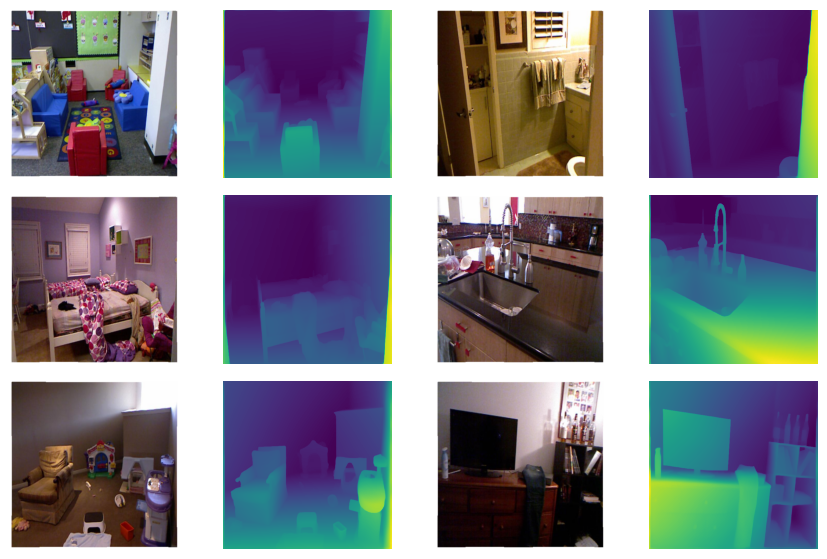

In [117]:
rows = 3
cols = 4
f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(11,7))
i = 0
j = 0
for input_image, depth_image in zip(input_images, depth_images):
    axes[i,j].axis("off")
    axes[i,j].imshow(input_image)
    axes[i,j].set_aspect("equal")
    j += 1
    axes[i,j].axis("off")
    axes[i,j].imshow(depth_image)
    axes[i,j].set_aspect("equal")
    if j == cols-1:
        j = 0
        i += 1
    else:
        j += 1

plt.subplots_adjust(hspace=0.1,wspace=0)